In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import json
from tqdm import tqdm

In [2]:
device = "cuda:0"
model_path = "LayTExtLLM/LayTextLLM-Zero"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code = True, padding_side = 'left')
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code = True).to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
## model generation setup
generate_params = {
    "use_cache": True,
    "do_sample": False,
    "num_beams": 1,
    "max_new_tokens": 512,
    "min_new_tokens": None,
    "top_p": 0.9,
    "repetition_penalty": 1.0,
    "length_penalty": 1.0,
    "num_return_sequences": 1,
    "temperature": 1.0,
    "output_scores": True,
    "output_hidden_states": True,
    "output_attentions": True,
    "return_dict_in_generate": True,
    "keyword": None
}

In [4]:
BOX_TOKEN = "<unk>"
BOX_TOKEN_ID = 0
INPUT_PROMPT_TEMPLATE = "given document <document>{ocr}</document>, answer following question: {question} Please think step-by-step.\n## answer:"

with open("../datasets/funsd_test.json", "r") as fin:
    test_data = json.load(fin)

print('==========num examples', len(test_data))

==========num examples 648


In [5]:
with torch.no_grad():
    for idx,example in enumerate(tqdm(test_data[2:3])):

        input_ids, input_polys = [], []
        img_size = {}

        texts = example['ocr']
        polys = example['poly']
        w, h = example['img_size']['w'], example['img_size']['h']
        question = example['question']
        answer = example['answer']
        meta = example['metadata']

        ## if ocr is empty, skip this example
        if len(texts) == 0:
            continue

        ## prepare input text ids, and layout polys
        for text, poly in zip(texts, polys):
            input_ids += [BOX_TOKEN_ID]
            text_ids = tokenizer.encode(text, add_special_tokens=False)
            input_ids += text_ids
            text_poly = [poly[0]/w,poly[1]/h,poly[4]/w,poly[5]/h]
            input_polys.append(text_poly)

        # extract layout embeddings
        input_polys = torch.as_tensor(input_polys).unsqueeze(0).to(device)

        # extract text embeddings
        # assign template to input texts
        input_data = {"ocr": tokenizer.decode(input_ids), "question": question}
        input_texts = INPUT_PROMPT_TEMPLATE.format(**input_data)

        # extract text ids
        input_ids = tokenizer.encode(input_texts, add_special_tokens=False)
        input_ids = torch.as_tensor(input_ids).unsqueeze(0).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        # Forward pass with attention extraction
        # outputs = model(
        #     input_ids=input_ids,
        #     laytout_input=input_polys,
        #     attention_mask=attention_mask,
        #     output_attentions=True
        #     )
        # attentions = outputs.attentions 

        model_output = model.generate(
                input_ids=input_ids,
                laytout_input=input_polys,
                attention_mask=attention_mask,
                **generate_params
            )

  0%|          | 0/1 [00:00<?, ?it/s]/home/tiger/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


In [6]:
output_ids = model_output.sequences[0]
output_str = tokenizer.decode(output_ids, skip_special_tokens=False)
print(output_str)

given document <document><unk> ATT.<unk> GEN.<unk> ADMIN.<unk> OFFICE<unk> Fax:<unk> 614<unk> -466<unk> -5087<unk> Dec<unk> 10<unk> '98<unk> 17<unk> :46<unk> P.<unk> 01<unk><unk> Attorney<unk> General<unk> D.<unk> Betty<unk> Montgomery<unk> CONFIDENTIAL<unk> FACSIMILE<unk> TRANSMISSION<unk> COVER<unk> SHEET<unk> FAX<unk> NO.<unk> (614)<unk> 466-<unk> 5087<unk> TO:<unk> George<unk> Baroody<unk> FAX<unk> NUMBER:<unk> (336)<unk> 335-<unk> 7392<unk> PHONE<unk> NUMBER:<unk> (336)<unk> 335-<unk> 7363<unk> DATE:<unk> 12<unk> /10<unk> /98<unk> NUMBER<unk> OF<unk> INCLUDING<unk> COVER<unk> SHEET:<unk> PAGES<unk> 3<unk> SENDER<unk> /PHONE<unk> NUMBER:<unk> June<unk> Flynn<unk> for<unk> Eric<unk> Brown/<unk> (614)<unk> 466-<unk> 8980<unk> SPECIAL<unk> INSTRUCTIONS:<unk> NOT<unk> OF<unk> THE<unk> PAGES<unk> IF<unk> YOU<unk> DO<unk> RECEIVE<unk> ANY<unk> PROPERLY,<unk> PLEASE<unk> CONTACT<unk> SENDER<unk> AS<unk> SOON<unk> AS<unk> POSSIBLE<unk> NOTE:<unk> THIS<unk> MESSAGE<unk> IS<unk> INTENDED<unk

In [7]:
area = [142, 438, 635, 453]
x_min, y_min, x_max, y_max = area[0]/1000,  area[1]/1000,  area[2]/1000,  area[3]/1000
width, height = 754, 1000
abs_x_min, abs_y_min, abs_x_max, abs_y_max = x_min*width, y_min*height, x_max*width, y_max*height

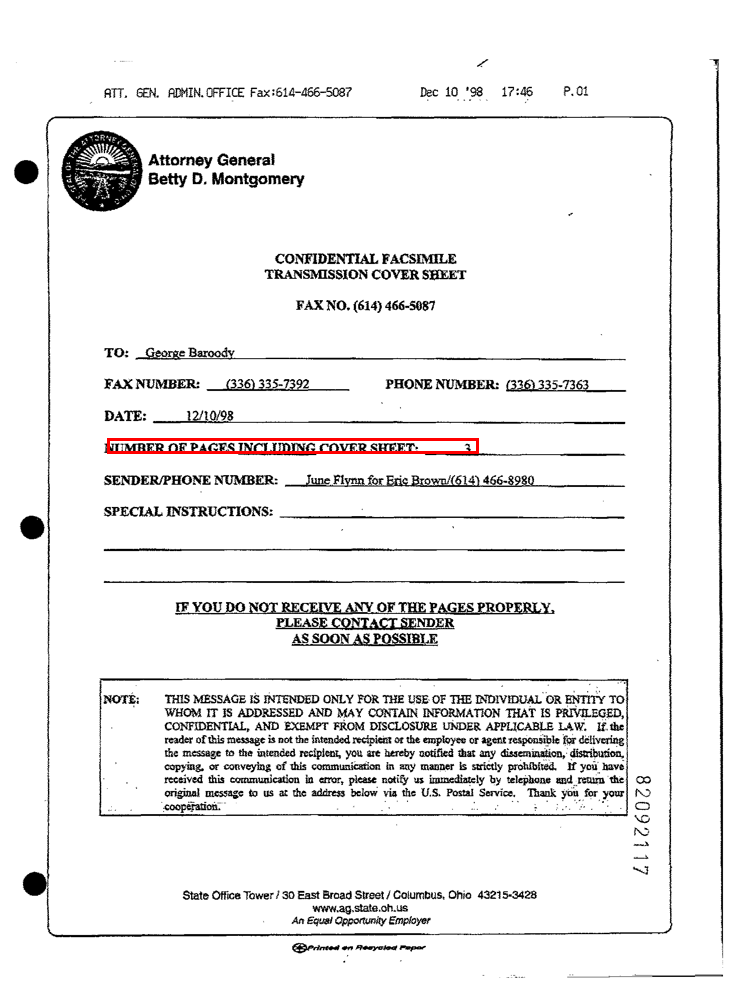

In [8]:
from PIL import Image, ImageDraw

# Open the black-and-white image (grayscale mode 'L')
image_path = '82092117.png'  # Replace with your image path
image = Image.open(image_path)

# Convert the grayscale image to RGB to allow for color drawing
image = image.convert("RGB")

# Create a drawing object
draw = ImageDraw.Draw(image)

# Define the bounding box coordinates (x1, y1, x2, y2)
bounding_box = (abs_x_min, abs_y_min, abs_x_max, abs_y_max)  # Replace with your bounding box coordinates

# Draw the bounding box (outline with color and width)
draw.rectangle(bounding_box, outline='red', width=3)

# Show the image
image.show()

# Optionally save the image with the bounding box
output_path = 'funsd_with_bbx.pdf'
image.save(output_path, format="pdf", bbox_inches="tight")
